In [16]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain

In [10]:
df = pd.read_csv('9748_demo_primary_tweets.csv', delimiter=',')
df.shape

(9748, 13)

In [11]:
df.head()

,Unnamed: 0,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,0,2019-11-28 04:52:58,csgazette,NaN,0,0,0,She's the fifth high-profile candidate to with...,NaN,@eluning,NaN,1199914055663857665,https://twitter.com/csgazette/status/119991405...
1,1,2019-11-28 02:18:01,lacadri34,Generalyeo,1,0,3,So since certain candidates with zero path to ...,NaN,NaN,NaN,1199875060158337025,https://twitter.com/lacadri34/status/119987506...
2,2,2019-11-28 01:18:58,frank07093,DreamReliquary,1,0,1,It's been 18 years since 9/11. Barbara Lee was...,NaN,NaN,NaN,1199860200381014016,https://twitter.com/frank07093/status/11998602...
3,3,2019-11-27 23:18:46,Fedjsicle,austinyorski,0,0,0,The best option for a Democratic Socialist par...,NaN,NaN,NaN,1199829951480025088,https://twitter.com/Fedjsicle/status/119982995...
4,4,2019-11-27 22:27:00,LibbyHa80071391,realDonaldTrump,0,0,0,Many economists view the continued economic gr...,NaN,NaN,NaN,1199816924110163970,https://twitter.com/LibbyHa80071391/status/119...


# Check data

In [12]:
df = df[['date', 'username', 'text']]
df = df.dropna()
df.shape

(9748, 3)

In [13]:
df['date'].min()

'2019-08-01 20:05:21'

In [14]:
df['date'].max()

'2019-11-28 04:52:58'

In [15]:
len(df['username'].value_counts())

8050

# preprocess tweets

In [22]:
%%time
# tokenization = split sentences into word strings
df['tokens'] = df['text'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 4.71 s


# Check frequency

In [23]:
pd.set_option('display.max_rows', 500)

#create [[str, str,...] ...] and chain(*) returns each str in each list 
all_words = pd.Series(chain(*list(df['processed']))) 
word_frequency = all_words.value_counts()
word_frequency

democratic                                                                                                                                                             7775
candidate                                                                                                                                                              6165
presidential                                                                                                                                                           6080
http                                                                                                                                                                   4007
…                                                                                                                                                                      3128
president                                                                                                                                   

# top 10 candidates

In [24]:
candidate_list = ["bennet", "biden", "bloomberg", "booker", "bullock", "buttigieg",\
                  "castro", "delaney", "babbard", "harris", "klobuchar", "patrick",\
                  "sanders", "sestak", "steyer", "warren", "williamson", "yang"]

In [25]:
tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(candidate_list)
candidate_frequency = word_frequency[mask]
top10_candidates = candidate_frequency.head(10)
top10_candidates

biden        1009
warren        548
bloomberg     504
sanders       375
buttigieg     356
harris        273
steyer        174
yang          158
patrick       143
klobuchar     128
dtype: int64

# lift ratios between candidates

In [26]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

In [27]:
lift_candidates = pd.DataFrame(top10_candidates.index.values, columns=['candidates']) #initialize df 
for candidate in top10_candidates.index.values:
    lift_candidates[candidate] = lift_candidates['candidates'].map(lambda x: lift(x, candidate)) #create lift column for each candidate 
lift_candidates = lift_candidates.set_index('candidates')
lift_candidates

,biden,warren,bloomberg,sanders,buttigieg,harris,steyer,yang,patrick,klobuchar
candidates,,,,,,,,,,
biden,9.718843,3.251460,0.522727,3.248277,2.757312,2.776812,0.949542,2.521978,0.135928,3.492709
warren,3.251460,17.820841,0.745493,8.290979,5.156030,5.940280,1.433861,5.301136,0.249243,7.100491
bloomberg,0.522727,0.745493,19.418327,0.934572,0.163638,0.071129,2.343591,0.368702,2.308472,0.758528
sanders,3.248277,8.290979,0.934572,26.064171,7.028541,7.733325,1.797529,7.753266,0.546801,10.181317
buttigieg,2.757312,5.156030,0.163638,7.028541,27.382022,7.823435,2.045783,7.452069,0.191483,19.039062
harris,2.776812,5.940280,0.071129,7.733325,7.823435,35.706960,4.719885,9.039737,0.249699,12.553228
steyer,0.949542,1.433861,2.343591,1.797529,2.045783,4.719885,56.022989,4.254911,0.783538,3.939116
yang,2.521978,5.301136,0.368702,7.753266,7.452069,9.039737,4.254911,61.696203,0.431442,15.424051
patrick,0.135928,0.249243,2.308472,0.546801,0.191483,0.249699,0.783538,0.431442,68.167832,1.065122


C:\Users\tsblo\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


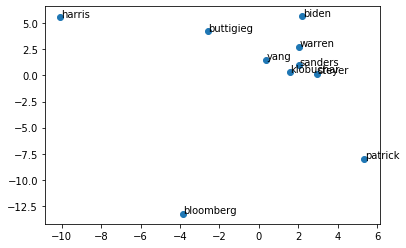

In [31]:
inverse_lift_candidates = lift_candidates.apply(lambda x: 1/x)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline  

embedding = MDS(n_components=2, random_state=10)
mds = embedding.fit_transform(inverse_lift_candidates)
mds_output = pd.DataFrame(mds, index=inverse_lift_candidates.index.values, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for candidate in inverse_lift_candidates.index.values:
    ax.text(mds_output.loc[candidate, 'x']+0.02, mds_output.loc[candidate, 'y']+0.02, candidate)

# policy connections

In [32]:
word_frequency[:500]

democratic                                                                    7775
candidate                                                                     6165
presidential                                                                  6080
http                                                                          4007
…                                                                             3128
president                                                                     2371
primary                                                                       2253
’                                                                             2027
debate                                                                        2002
since                                                                         1877
trump                                                                         1303
2020                                                                          1270
ha  

In [34]:
policy_dict = { "leadership": ["lead", "plan", "leading", "help", "qualified"],
                "experience":["former", "know"],
                "popularity":["support", "want", "win", "top", "watch", "best", "back", "potential", "great", "believe"],
                "progressive": ["change"], 
                "education": ["school"],
                "taxes": ["tax"],
                "jobs": ["work"],
                "health": ["health", "care"]}

In [36]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_policy = pd.DataFrame(pd.Series(policy_dict), columns=['policy_terms'])
top_policy['count'] = top_policy['policy_terms'].map(lambda x: count_attribute(df, x))

top_policy.sort_values(by=['count'], ascending=False)[:5]

,policy_terms,count
popularity,"[support, want, win, top, watch, best, back, p...",2046
leadership,"[lead, plan, leading, help, qualified]",1094
experience,"[former, know]",813
health,"[health, care]",168
progressive,[change],158


In [37]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [38]:
candidates_list = top10_candidates[:5]

for attribute in top_policy.index.values:
    print(attribute)
    output = lift_attribute_to_brands(attribute, policy_dict, candidates_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(output)
    print('')

leadership
biden        4.113185
warren       1.987333
sanders      1.667726
buttigieg    1.576844
bloomberg    0.337247
dtype: float64

experience
bloomberg    3.463293
biden        1.912688
sanders      0.737363
buttigieg    0.707285
warren       0.591836
dtype: float64

popularity
bloomberg    1.490067
sanders      1.006388
biden        1.002285
warren       0.905849
buttigieg    0.749459
dtype: float64

progressive
sanders      3.299262
warren       2.819753
buttigieg    2.079647
biden        1.414768
bloomberg    0.491603
dtype: float64

education
buttigieg    0.842524
sanders      0.601481
biden        0.224281
warren       0.137083
bloomberg    0.000000
dtype: float64

taxes
warren       4.489219
bloomberg    2.519936
sanders      0.994816
buttigieg    0.627069
biden        0.222569
dtype: float64

jobs
sanders      1.050975
warren       0.574866
buttigieg    0.220823
biden        0.156756
bloomberg    0.156599
dtype: float64

health
warren       1.378994
sanders      0.930863
b